In [1]:
import sys

sys.path.append("../")  # up one level

import os
import shutil

import gcsfs
import geopandas as gpd
import pandas as pd
from calitp_data_analysis.sql import to_snakecase
from calitp_data_analysis.tables import tbls
from segment_speed_utils.project_vars import PUBLIC_GCS
from siuba import _, collect, count, filter, select, show_query
from update_vars import GCS_FILE_PATH, NTD_MODES, NTD_TOS

GCS_FILE_PATH = "gs://calitp-analytics-data/data-analyses/ntd/"

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

# Work plan

## Need List of all annual reporters
- Full, Reduced, Rural reporters all submit an annual Report to NTD

## Need to assign rural and reduced annual reporters to RTPAs
- Full reporters are already mapped to RTPAs via the monthly report
- but reduced and rurap reporters need to be mapped to RTPAs

### How to traverse operators to RTPA?
- find all the operators in a GTFS schedule. 
- do any of the rural operators appear in a schedule?
    - if so, then what is the RTPA of that schedule!!!!!
    - ntd > operator > schedule > RTPA 

## Read in `dim_annual_service_agencies` to get metrics
but need to RTPA info to this data

In [2]:
# dim_annual_service_agenices is the annual report module.
# included uza, VRM, VRH, UPT
# report years include 2022-2023

ntd_service = (
    tbls.mart_ntd.dim_annual_service_agencies()
    >> filter(_.state == "CA")
    >> select(
        "report_year",
        "ntd_id",
        "agency",
        "reporter_type",
        "organization_type",
        "city",
        "state",
        "primary_uza_name",
        "actual_vehicles_passenger_car_revenue_hours",
        "actual_vehicles_passenger_car_revenue_miles",
        "unlinked_passenger_trips_upt",
    )
    >> collect()
)
ntd_service.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421 entries, 0 to 420
Data columns (total 11 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   report_year                                  421 non-null    int64  
 1   ntd_id                                       421 non-null    object 
 2   agency                                       421 non-null    object 
 3   reporter_type                                421 non-null    object 
 4   organization_type                            421 non-null    object 
 5   city                                         418 non-null    object 
 6   state                                        421 non-null    object 
 7   primary_uza_name                             328 non-null    object 
 8   actual_vehicles_passenger_car_revenue_hours  421 non-null    float64
 9   actual_vehicles_passenger_car_revenue_miles  421 non-null    float64
 10  un

### update `ntd_service` to:
- 90227 City of Moorpark > city = Moorpark
- 90253 City of Bell Gardens > city = Bell Gardens
- 90259 City of Cerritos > city = Cerritos
- 90286 City of Monterey Park > city = Monterey Park

In [3]:
#Moorpark Update
ntd_service.loc[ntd_service["ntd_id"]=="90227","city"] = "Moorpark"

# Bell Gardens Update
ntd_service.loc[ntd_service["ntd_id"]=="90253","city"] = "Bell Gardens"

# Cerritos Update
ntd_service.loc[ntd_service["ntd_id"]=="90259","city"] = "Cerritos"

# Monterey Park Update
ntd_service.loc[ntd_service["ntd_id"]=="90286","city"] = "Monterey Park"

In [4]:
display(
#Moorpark Update
    ntd_service.loc[ntd_service["ntd_id"]=="90227","city"],

# Bell Gardens Update
    ntd_service.loc[ntd_service["ntd_id"]=="90253","city"],

# Cerritos Update
    ntd_service.loc[ntd_service["ntd_id"]=="90259","city"],

# Monterey Park Update
    ntd_service.loc[ntd_service["ntd_id"]=="90286","city"]
    
)

294    Moorpark
295    Moorpark
Name: city, dtype: object

314    Bell Gardens
315    Bell Gardens
Name: city, dtype: object

326    Cerritos
327    Cerritos
Name: city, dtype: object

376    Monterey Park
377    Monterey Park
Name: city, dtype: object

### Does `ntd_id-to-rtap crosswalk` include rural/reduced reporter info?

In [5]:
# reading in NTD ID crosswalk from GCS
ntd_rtpa_crosswalk = pd.read_csv(
    f"{GCS_FILE_PATH}ntd_id_rtpa_crosswalk.csv", dtype={"ntd_id": "str"}
).rename(columns={"NTD ID": "ntd_id"})

ntd_rtpa_crosswalk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122 entries, 0 to 121
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ntd_id          122 non-null    object
 1   Legacy NTD ID   111 non-null    object
 2   Agency          122 non-null    object
 3   UZA Name        121 non-null    object
 4   RTPA_open_data  122 non-null    object
 5   RTPA            122 non-null    object
dtypes: object(6)
memory usage: 5.8+ KB


In [6]:
# are all agencies in the ntd_service in the crosswalk? NO
check = ntd_service.merge(ntd_rtpa_crosswalk, on="ntd_id", how="left", indicator=True)

# the rural reporters are not in the ntd_rtpa_crosswalk
check[check["_merge"] == "left_only"]["reporter_type"].value_counts()

Reduced Reporter    132
Rural Reporter       89
Name: reporter_type, dtype: int64

In [7]:
# crosswalk[["UZA Name", "RTPA"]].sort_values(by="UZA Name")

Some UZA Names can go to multiple RTPAs
- some agencies in the Sacramento UZA go to Sac and Placer RTPA
- some agencies in LA UZA got to Metro or OCTA


In [8]:
# just rural/reduced reporters
rural_reduced_reporters = ntd_service[
    ntd_service["reporter_type"] != "Full Reporter"
].sort_values(by="primary_uza_name")

In [9]:
# rural_reduced_reporters.to_csv("rural_reduced_reporters.csv")

## Get all operators from RTPA using function from Tiffany

via [slack thread](https://cal-itp.slack.com/archives/C02H6JUSS9L/p1729102048291249)

initial work done in `rtpa_operator_explore.ipynb`

- rip `create_gtfs_dataset_key_to_organization_crosswalk` function from `gtfs_funnel/crosswalk_gtfs_dataset_key_to_organization.py`
- rip any date from GCS (latest is 2025-01-15) `calitp-analytics-data/data-analyses/gtfs_schedule/crosswalk`
- find the corresponding `gtfs_key-to-org crosswalk` by date (2025-01-15) via `calitp-analytics-data/data-analyses/gtfs_schedule/crosswalk`

can use these 2 dataframes to go from `schedule_gtfs_dataset_key (operator)` > `ntd_id`

A single schedule feed can have multiple operators. This is how you identify 

In [10]:
# need this to run `create_gtfs_dataset_key_to_organzaition_crosswalk`
from segment_speed_utils import helpers
from shared_utils.schedule_rt_utils import (
    sample_gtfs_dataset_key_to_organization_crosswalk,
)

In [11]:
def create_gtfs_dataset_key_to_organization_crosswalk(
    analysis_date: str,
) -> pd.DataFrame:
    """
    For every operator that appears in schedule data,
    create a crosswalk that links to organization_source_record_id.
    For all our downstream outputs, at various aggregations,
    we need to attach these over and over again.
    """
    df = helpers.import_scheduled_trips(
        analysis_date, columns=["gtfs_dataset_key", "name"], get_pandas=True
    ).rename(columns={"schedule_gtfs_dataset_key": "gtfs_dataset_key"})
    # rename columns because we must use simply gtfs_dataset_key in schedule_rt_utils function

    # Get base64_url, organization_source_record_id and organization_name
    crosswalk = sample_gtfs_dataset_key_to_organization_crosswalk(
        df,
        analysis_date,
        quartet_data="schedule",
        dim_gtfs_dataset_cols=["key", "source_record_id", "base64_url"],
        dim_organization_cols=[
            "source_record_id",
            "name",
            "itp_id",
            "caltrans_district",
            "ntd_id_2022",
        ],
    )

    df_with_org = pd.merge(
        df.rename(columns={"gtfs_dataset_key": "schedule_gtfs_dataset_key"}),
        crosswalk,
        on="schedule_gtfs_dataset_key",
        how="inner",
    )

    return df_with_org

In [12]:
# get gtfs to org df,
# same date as used below
gtfs_to_org = create_gtfs_dataset_key_to_organization_crosswalk(
    "2025-01-15"  # 216 total rows
    # "2024-10-14" #209 rows
    # "2024-08-14" #206 rows
    # "2024-03-13" #193 rows
).rename(columns={"name": "schedule_name"})


gtfs_to_org.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 216 entries, 0 to 215
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   schedule_gtfs_dataset_key      216 non-null    object 
 1   schedule_name                  216 non-null    object 
 2   schedule_source_record_id      216 non-null    object 
 3   base64_url                     216 non-null    object 
 4   organization_source_record_id  216 non-null    object 
 5   organization_name              216 non-null    object 
 6   itp_id                         204 non-null    float64
 7   caltrans_district_x            214 non-null    object 
 8   ntd_id_2022                    172 non-null    object 
 9   caltrans_district_y            216 non-null    object 
dtypes: float64(1), object(9)
memory usage: 18.6+ KB


In [13]:
# initialize gtfs rosswalk
gtfs_key_orgs = pd.read_parquet(
    "gs://calitp-analytics-data/data-analyses/gtfs_schedule/crosswalk/gtfs_key_organization_2025-01-15.parquet"
)
gtfs_key_orgs.columns # not sure i cant use these columns

Index(['schedule_gtfs_dataset_key', 'name', 'schedule_source_record_id',
       'base64_url', 'organization_source_record_id', 'organization_name',
       'caltrans_district', 'counties_served', 'hq_city', 'hq_county',
       'is_public_entity', 'is_publicly_operating', 'funding_sources',
       'on_demand_vehicles_at_max_service', 'vehicles_at_max_service',
       'number_of_state_counties', 'primary_uza_name', 'density',
       'number_of_counties_with_service', 'state_admin_funds_expended',
       'service_area_sq_miles', 'population', 'service_area_pop',
       'subrecipient_type', 'primary_uza_code', 'reporter_type',
       'organization_type', 'voms_pt', 'voms_do', 'year'],
      dtype='object')

## Merge `ntd_service` data to `gtfs_to_orgs` list
Results should be the ntd_service data with the GTFS schedule name 

In [14]:
keep_cols = [
    "schedule_gtfs_dataset_key",
    "schedule_name",
    "organization_name",
    "ntd_id_2022",
]

ntd_metrics_to_sched = ntd_service.merge(
    gtfs_to_org[keep_cols],
    right_on="ntd_id_2022",
    left_on="ntd_id",
    how="left",
    indicator=True,
)
display(ntd_metrics_to_sched.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 455 entries, 0 to 454
Data columns (total 16 columns):
 #   Column                                       Non-Null Count  Dtype   
---  ------                                       --------------  -----   
 0   report_year                                  455 non-null    int64   
 1   ntd_id                                       455 non-null    object  
 2   agency                                       455 non-null    object  
 3   reporter_type                                455 non-null    object  
 4   organization_type                            455 non-null    object  
 5   city                                         455 non-null    object  
 6   state                                        455 non-null    object  
 7   primary_uza_name                             356 non-null    object  
 8   actual_vehicles_passenger_car_revenue_hours  455 non-null    float64 
 9   actual_vehicles_passenger_car_revenue_miles  455 non-null    floa

None

In [15]:
ntd_metrics_to_sched["_merge"].value_counts()
# so there are some left-only rows, meaning some operators did not match to schedule
# on date 2025-01-15: 257 both, 88 left_only = 88 reporters did not match to a shcedule

both          326
left_only     129
right_only      0
Name: _merge, dtype: int64

In [16]:
# what are the reporter types for these left_only operators?
ntd_metrics_to_sched[ntd_metrics_to_sched["_merge"] == "left_only"][
    "reporter_type"
].value_counts()  # 65 reduced, 23 full reporters

# also checked "both" and got mix of full, reduced and rural
# may need to check a different crosswalk data

Reduced Reporter    74
Rural Reporter      32
Full Reporter       23
Name: reporter_type, dtype: int64

In [17]:
# looking into the cities of the left_only merges
ntd_metrics_to_sched[ntd_metrics_to_sched["_merge"] == "left_only"][
    ["agency", "reporter_type", "city"]
].value_counts()

agency                                                                          reporter_type     city            
Los Angeles County                                                              Reduced Reporter  Alhambra            9
Access Services                                                                 Full Reporter     El Monte            2
City of Malibu                                                                  Reduced Reporter  Malibu              2
Paratransit, Inc.                                                               Full Reporter     Sacramento          2
City of Covina                                                                  Reduced Reporter  Covina              2
City of Davis, dba: Davis Community Transit                                     Reduced Reporter  Davis               2
Easy Lift Transportation                                                        Reduced Reporter  Goleta              2
City of Huntington Park                      

In [18]:
# if i sort by city, can i match copy the RTPA of the good rows to the left_only rows?
ntd_metrics_to_sched[
    ["agency", "city", "schedule_gtfs_dataset_key", "schedule_name", "_merge"]
].sort_values(by=["city", "agency"], ascending=True).head(10)

,agency,city,schedule_gtfs_dataset_key,schedule_name,_merge
334,City of Agoura Hills,Agoura Hills,NaN,NaN,left_only
335,City of Agoura Hills,Agoura Hills,NaN,NaN,left_only
336,"City of Alhambra, dba: Alhambra Community Transit",Alhambra,9471fbb88956076b211cc4a8df1a536c,Alhambra Schedule,both
337,"City of Alhambra, dba: Alhambra Community Tran...",Alhambra,9471fbb88956076b211cc4a8df1a536c,Alhambra Schedule,both
380,Los Angeles County,Alhambra,NaN,NaN,left_only
382,Los Angeles County,Alhambra,2606479845d2cf0077fac54ff25a3a69,LADPW Schedule,both
385,Los Angeles County,Alhambra,NaN,NaN,left_only
386,Los Angeles County,Alhambra,NaN,NaN,left_only
388,Los Angeles County,Alhambra,NaN,NaN,left_only
390,Los Angeles County,Alhambra,NaN,NaN,left_only


## merge `ntd_metrics_to_sched` df to `ntd_to_rtpa` crosswalk
Result should be a df of ntd service reports with GTFS schedule, then RTPA name merged in

In [19]:
metrics_sched_rtpa = ntd_metrics_to_sched.drop(columns="_merge", axis=1).merge(
    ntd_rtpa_crosswalk, on="ntd_id", how="left", indicator=True
)

metrics_sched_rtpa.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 457 entries, 0 to 456
Data columns (total 21 columns):
 #   Column                                       Non-Null Count  Dtype   
---  ------                                       --------------  -----   
 0   report_year                                  457 non-null    int64   
 1   ntd_id                                       457 non-null    object  
 2   agency                                       457 non-null    object  
 3   reporter_type                                457 non-null    object  
 4   organization_type                            457 non-null    object  
 5   city                                         457 non-null    object  
 6   state                                        457 non-null    object  
 7   primary_uza_name                             358 non-null    object  
 8   actual_vehicles_passenger_car_revenue_hours  457 non-null    float64 
 9   actual_vehicles_passenger_car_revenue_miles  457 non-null    floa

In [20]:
metrics_sched_rtpa["_merge"].value_counts()
# on date 2025-01-15: 227 both, 120 left_only = 120 reporters did not match to a RTPA
# ideally want every row to match

left_only     229
both          228
right_only      0
Name: _merge, dtype: int64

In [21]:
# get DF of agencies > reporter type > city > schedule name > rtpa
# if 2 reporters share the same City, then are they part of the same schedule? or part of the same RTPA?

metrics_sched_rtpa[
    [
        "report_year",
        "ntd_id",
        "agency",
        "reporter_type",
        "city",
        "schedule_name",
        "RTPA",
    ]
].sort_values(by=["city", "RTPA"], ascending=True)

# examples to pull: Camarillo, Riverside, 

,report_year,ntd_id,agency,reporter_type,city,schedule_name,RTPA
336,2023,90246,City of Agoura Hills,Reduced Reporter,Agoura Hills,NaN,NaN
337,2022,90246,City of Agoura Hills,Reduced Reporter,Agoura Hills,NaN,NaN
338,2023,90247,"City of Alhambra, dba: Alhambra Community Transit",Reduced Reporter,Alhambra,Alhambra Schedule,NaN
339,2022,90247,"City of Alhambra, dba: Alhambra Community Tran...",Reduced Reporter,Alhambra,Alhambra Schedule,NaN
380,2022,90269,Los Angeles County Dept. of Public Works - Ath...,Reduced Reporter,Alhambra,NaN,NaN
381,2023,90269,"Los Angeles County, dba: LA County Public Works",Reduced Reporter,Alhambra,NaN,NaN
382,2023,90270,Los Angeles County,Reduced Reporter,Alhambra,NaN,NaN
383,2022,90270,Los Angeles County Department of Public Works ...,Reduced Reporter,Alhambra,NaN,NaN
384,2023,90271,Los Angeles County,Reduced Reporter,Alhambra,LADPW Schedule,NaN
385,2022,90271,Los Angeles County Department of Public Works ...,Reduced Reporter,Alhambra,LADPW Schedule,NaN


## try merging GDF of city in dim_services to RTPA bounaries.
- To match agency cities to RTPAs. (this method doesnt need schedule info)

Census Designated Places (CDPs) 2010 - California map
-https://data.sacog.org/datasets/SACOG::census-designated-places-cdps-2010-california/about

~~California Incorporated Cities (dont think this included census derived places or unincorporated areas.)~~
~~- https://gis.data.cnra.ca.gov/datasets/CALFIRE-Forestry::california-incorporated-cities-1/explore~~

RTPA map opend data
- https://www.lab.data.ca.gov/dataset/regional-transportation-planning-agencies

In [22]:
import geopandas as gpd

In [50]:
rtpa_url = "https://cecgis-caenergy.opendata.arcgis.com/api/download/v1/items/3a83743378be4e7f84c8230889c01dea/geojson?layers=0"
rtpa_map = gpd.read_file(rtpa_url)[["RTPA","LABEL_RTPA","geometry"]]#.set_crs("ESRI:102600", allow_override=True)

In [50]:
# California Incorporated Cities!!!!! dont think this included census derived places or unincorporated areas.
cities_url="https://gis.data.cnra.ca.gov/api/download/v1/items/8322505e8f1741c7b0de85684594e32a/geojson?layers=0"
cities_map =gpd.read_file(cities_url)[["COUNTY","CITY","geometry"]]#.set_crs("ESRI:102600", allow_override=True)

In [75]:
# California Census Designated Places (2010), includes cities and CDPs
# there are some duplicate cdp names, need to agg by 

cdp_url="https://services6.arcgis.com/YBp5dUuxCMd8W1EI/arcgis/rest/services/California_Census_Designated_Places_2010/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson"
keep_cdp_col=["NAME10","NAMELSAD10","geometry"]
cdp_map= gpd.read_file(cdp_url)
print(cdp_map.columns)

cdp_map= cdp_map[keep_cdp_col].rename(columns={"NAME10":"cdp_name","NAMELSAD10":"name_lsad"})

Index(['FID', 'STATEFP10', 'PLACEFP10', 'PLACENS10', 'GEOID10', 'NAME10',
       'NAMELSAD10', 'LSAD10', 'CLASSFP10', 'PCICBSA10', 'PCINECTA10',
       'MTFCC10', 'FUNCSTAT10', 'ALAND10', 'AWATER10', 'INTPTLAT10',
       'INTPTLON10', 'Shape_STAr', 'Shape_STLe', 'geometry'],
      dtype='object')


In [76]:
display(
    cdp_map.info(),
    cdp_map.crs,
    cdp_map["cdp_name"].value_counts().head(),
    cdp_map[cdp_map["cdp_name"]=="Green Valley"]
)

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1523 entries, 0 to 1522
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   cdp_name   1523 non-null   object  
 1   name_lsad  1523 non-null   object  
 2   geometry   1523 non-null   geometry
dtypes: geometry(1), object(2)
memory usage: 35.8+ KB


None

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Green Valley    2
Cold Springs    2
El Cerrito      2
Greenfield      2
Bear Valley     2
Name: cdp_name, dtype: int64

,cdp_name,name_lsad,geometry
1427,Green Valley,Green Valley CDP,"POLYGON ((-118.36717 34.62322, -118.36699 34.6..."
1432,Green Valley,Green Valley CDP,"POLYGON ((-122.14977 38.28569, -122.14854 38.2..."


In [86]:
cdp_map[cdp_map["cdp_name"]=="Green Valley"][:1].explore()

In [87]:
cdp_map[cdp_map["cdp_name"]=="Green Valley"][1:].explore()

In [25]:
display(
    rtpa_map.info(),
    rtpa_map.crs,
    rtpa_map.head()
)

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 43 entries, 0 to 42
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   RTPA        43 non-null     object  
 1   LABEL_RTPA  43 non-null     object  
 2   geometry    43 non-null     geometry
dtypes: geometry(1), object(2)
memory usage: 1.1+ KB


None

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

,RTPA,LABEL_RTPA,geometry
0,Alpine County Local Transportation Commission,Alpine LTC,"POLYGON ((-119.58544 38.71321, -119.58493 38.7..."
1,Amador County Transportation Commission,Amador CTC,"POLYGON ((-120.07239 38.70277, -120.07239 38.7..."
2,Butte County Association of Governments,BCAG,"POLYGON ((-121.07669 39.59726, -121.07954 39.5..."
3,Calaveras Council of Governments,Calaveras COG,"POLYGON ((-120.01995 38.43352, -120.02020 38.4..."
4,Colusa County Transportation Commission,Colusa CTC,"POLYGON ((-121.89001 39.38386, -121.88995 39.3..."


## sjoin ~~`cities_map`~~ `cdp_map` gdf and `rtpa_map` gdf to attach RTPA name to cities

In [53]:
city_to_rtpa = gpd.sjoin(
    #cities_map, #only incorporated cities, not CDP are commonly known areas. 510 rows with left join
    cdp_map, # includes cities and CDPs. 1606 rows with left join
    rtpa_map,
    how="inner",
    predicate="intersects",
    #indicator=True
)



display(
    len(cdp_map),
    len(rtpa_map),
    city_to_rtpa.info(),
    city_to_rtpa.crs,

)

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 1605 entries, 0 to 1415
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   cdp_name     1605 non-null   object  
 1   name_lsad    1605 non-null   object  
 2   geometry     1605 non-null   geometry
 3   index_right  1605 non-null   int64   
 4   RTPA         1605 non-null   object  
 5   LABEL_RTPA   1605 non-null   object  
dtypes: geometry(1), int64(1), object(4)
memory usage: 87.8+ KB


1523

43

None

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [55]:
city_to_rtpa[city_to_rtpa["cdp_name"].str.contains("Avalon")] 
#Analon is on Catalina Island...dont think the RTPA map,


,cdp_name,name_lsad,geometry,index_right,RTPA,LABEL_RTPA


Avalon on rtpa_map
- need to manually place in SCAG

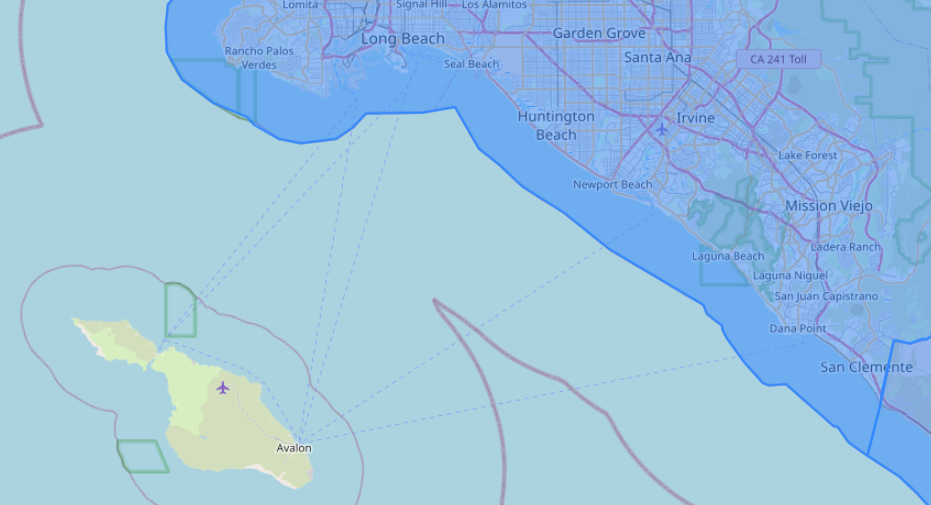

## merge `ntd_service` to `city_to_rtpa`
join on City. attach RTPA name to ntd annual data

In [56]:
display(
    ntd_service.info(), # annual NTD data 
    city_to_rtpa.columns
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421 entries, 0 to 420
Data columns (total 11 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   report_year                                  421 non-null    int64  
 1   ntd_id                                       421 non-null    object 
 2   agency                                       421 non-null    object 
 3   reporter_type                                421 non-null    object 
 4   organization_type                            421 non-null    object 
 5   city                                         421 non-null    object 
 6   state                                        421 non-null    object 
 7   primary_uza_name                             328 non-null    object 
 8   actual_vehicles_passenger_car_revenue_hours  421 non-null    float64
 9   actual_vehicles_passenger_car_revenue_miles  421 non-null    float64
 10  un

None

Index(['cdp_name', 'name_lsad', 'geometry', 'index_right', 'RTPA',
       'LABEL_RTPA'],
      dtype='object')

In [64]:
city_to_rtpa["cdp_name"].value_counts()

Kirkwood                             3
Bear Valley                          3
Folsom                               3
Lexington Hills                      2
Foresthill                           2
West Point                           2
Meadow Vista                         2
Mokelumne Hill                       2
Interlaken                           2
La Porte                             2
Sheridan                             2
Lebec                                2
Frazier Park                         2
Mountain House                       2
Citrus Heights                       2
Kingvale                             2
Friant                               2
Roseville                            2
Antioch                              2
Mad River                            2
Sea Ranch                            2
Camanche Village                     2
Greenfield                           2
Willow Creek                         2
Ridgecrest                           2
Rainbow                  

In [57]:
ntd_data_to_rtpa = ntd_service.merge(
    city_to_rtpa[["cdp_name","RTPA"]],
    left_on=("city"),
    right_on=("cdp_name"),
    how="left", # with left join, got some unmerged rows. aka cities that are dont appear in the city_to_rtpa list (CDP?)
    indicator=True
)
ntd_data_to_rtpa.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 442 entries, 0 to 441
Data columns (total 14 columns):
 #   Column                                       Non-Null Count  Dtype   
---  ------                                       --------------  -----   
 0   report_year                                  442 non-null    int64   
 1   ntd_id                                       442 non-null    object  
 2   agency                                       442 non-null    object  
 3   reporter_type                                442 non-null    object  
 4   organization_type                            442 non-null    object  
 5   city                                         442 non-null    object  
 6   state                                        442 non-null    object  
 7   primary_uza_name                             345 non-null    object  
 8   actual_vehicles_passenger_car_revenue_hours  442 non-null    float64 
 9   actual_vehicles_passenger_car_revenue_miles  442 non-null    floa

In [58]:
ntd_data_to_rtpa["_merge"].value_counts() # 12 left_only rows, who are there?



both          431
left_only      11
right_only      0
Name: _merge, dtype: int64



then Update `ntd_data_to_rtpa` with the following information:
- 90079 SunLine Transit > COUNTY = Riverside County. RTPA = Southern California Association of Governments
- 90229 El Dorado County Transit Authority > COUNTY = El Dorado County. RTPA =  El Dorado County Transportation Commission
- 90287 Palos Verdes Peninsula Transit Authority > COUNTY = Los Angeles County. RTPA = Southern California Association of Governments
- 91092 Tahoe Transportation District > COUNTY El Dorado County. RTPA = Tahoe Regional Planning Agency

In [60]:
ntd_data_to_rtpa[ntd_data_to_rtpa["_merge"]=="left_only"][["report_year","agency","city"]]
    
# most of these are sub/regions in CA, not actual cities or CDP. will need a manual edit



,report_year,agency,city
252,2022,City of McFarland,Mcfarland
253,2023,"City of McFarland, dba: McFarland City Transit...",Mcfarland
324,2023,"City of Avalon, dba: Avalon Transit",Avalon
325,2022,City of Avalon,Avalon
400,2022,Palos Verdes Peninsula Transit Authority,Palos Verdes Peninsula
419,2023,County of Ventura,Ventura
420,2022,County of Ventura,Ventura
435,2022,Chemehuevi Indian Tribe,Havasu Lake
436,2023,Chemehuevi Indian Tribe,Havasu Lake
439,2022,North Fork Rancheria of Mono Indians of Califo...,North Fork


In [62]:
# checking CDP names in cities lsit
city_check_list = list(ntd_data_to_rtpa[ntd_data_to_rtpa["_merge"]=="left_only"]["city"].unique())

pattern = "|".join(city_check_list)

display(
    city_check_list,
    city_to_rtpa[city_to_rtpa["cdp_name"].str.contains(pattern, case=False)],
    cdp_map[cdp_map["cdp_name"].str.contains(pattern, case=False)],
    #cdp_map[cdp_map["cdp_name"].str.contains("fork")]
)



['Mcfarland',
 'Avalon',
 'Palos Verdes Peninsula',
 'Ventura',
 'Havasu Lake',
 'North Fork']

,cdp_name,name_lsad,geometry,index_right,RTPA,LABEL_RTPA
600,San Buenaventura (Ventura),San Buenaventura (Ventura) city,"MULTIPOLYGON (((-119.31211 34.35749, -119.3122...",35,Southern California Association of Governments,SCAG
91,McFarland,McFarland city,"POLYGON ((-119.23197 35.68978, -119.23197 35.6...",12,Kern Council of Governments,KCOG


,cdp_name,name_lsad,geometry
91,McFarland,McFarland city,"POLYGON ((-119.23197 35.68978, -119.23197 35.6..."
600,San Buenaventura (Ventura),San Buenaventura (Ventura) city,"MULTIPOLYGON (((-119.31211 34.35749, -119.3122..."
862,Avalon,Avalon city,"POLYGON ((-118.32578 33.34403, -118.32559 33.3..."


,cdp_name,name_lsad,geometry
1002,Hayfork,Hayfork CDP,"POLYGON ((-123.06123 40.53371, -123.06163 40.5..."


## manual updates to `ntd_data_to_rtpa`
